#ReCom Chain



In [27]:
import random
random.seed(12345678)

In [28]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from functools import partial
import pandas as pd
import geopandas as gpd
import csv
import os
import datetime  #For keeping track of runtime
import tqdm # for progress bar

Adding time information can help you know how long you might need to run a longer chain.  It's not so useful for a jupyter notebook, but you may want to use it in your project.

In [29]:
beginrun = datetime.datetime.now()
print ("\nBegin date and time : ", beginrun.strftime("%Y-%m-%d %H:%M:%S"))


Begin date and time :  2025-04-21 11:10:37


We can create files for later analyses, if desired. <br>
I'll create files and put them in this directory:

In [96]:
outdir="./NM_recom/"

Here are some parameters that we can change later if we'd like. <br>
```save_district_plot_mod``` determines which plots (maps) we'll save.

In [91]:
total_steps_in_run=100
save_district_graph_mod=1
save_district_plot_mod=10

In [89]:
os.makedirs(outdir, exist_ok=True)
graph = Graph.from_file("NM/NM.shp")

first_node = list(graph.nodes)[0]

# Get all the column names / attribute keys
print(list(graph.nodes[first_node].keys()))
print(sum([graph.nodes[node]["TOTPOP"] for node in graph.nodes]))


['boundary_node', 'area', 'STATEFP', 'COUNTYFP', 'COUNTYNAME', 'VTDST', 'NAME', 'G20PRED', 'G20PRER', 'G20SACDIVE', 'G20SACRJOH', 'G20SACDHEN', 'G20SACRLEE', 'G20SACLCUR', 'G20SACDYOH', 'G20SACRMON', 'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'G18USSD', 'G18USSR', 'G18GOVD', 'G18GOVR', 'G18SOSD', 'G18SOSR', 'G18TRED', 'G18TRER', 'G18ATGD', 'G18ATGR', 'G18AUDD', 'G18AUDR', 'G18LNDD', 'G18LNDR', 'SACD', 'geometry']
2117522


These are the elections we have available:

In [45]:
elections = [
	Election("US_Sen_2018", {"Democratic": "G18USSD", "Republican": "G18USSR"}),
	Election("Governor_2018", {"Democratic": "G18GOVD", "Republican": "G18GOVR"}),
	Election("Pres_2020", {"Democratic": "G20PRED", "Republican": "G20PRER"}),
	Election("SoS_2018", {"Democratic": "G18SOSD", "Republican": "G18SOSR"}),
	Election("Treasurer_2018", {"Democratic": "G18TRED", "Republican": "G18TRER"}),
	Election("AG_2018", {"Democratic": "G18ATGD", "Republican": "G18ATGR"}),
	Election("Auditor_2018", {"Democratic": "G18AUDD", "Republican": "G18AUDR"}),
	Election("LandComm_2018", {"Democratic": "G18LNDD", "Republican": "G18LNDR"})
]

Remember the population updater is for computing how close to equality the district populations are. <br>
"TOT_POP" is the population column from our shapefile.

In [46]:
my_updaters = {"population": updaters.Tally("TOTPOP", alias="population")}

Election updaters, for computing election results using the vote totals from our shapefile.

In [47]:
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

In [57]:
initial_partition = GeographicPartition(graph,
                                        assignment= "SACD",
                                        updaters=my_updaters,)


The ReCom proposal needs to know the ideal population for the districts so that we can improve speed by bailing early on unbalanced partitions.

In [58]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

In [67]:
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.10,
                   node_repeats=2
                   )

In [68]:
compactness_bound = constraints.UpperBound(
	lambda p: len(p["cut_edges"]),
	2*len(initial_partition["cut_edges"])
)

In [72]:
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.12)

In [73]:
chain = MarkovChain(
	proposal=proposal,
	constraints=[
		pop_constraint,
		compactness_bound
	],
	accept=accept.always_accept,
	initial_state=initial_partition,
	total_steps=total_steps_in_run
)

## Signature of Gerrymandering

We will use the dataframe below to get `signature of gerrymandering'<br>
Much of this was taken from [https://gerrychain.readthedocs.io/en/latest/user/recom/#a-real-world-example](https://gerrychain.readthedocs.io/en/latest/user/recom/#a-real-world-example)

In [74]:
data = pd.DataFrame(
	sorted(partition["Pres_2020"].percents("Democratic"))
	for partition in chain.with_progress_bar()
)

C:\Users\Paul Maresquier\Documents\School\CS 464\NMHouse\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 100/100 [00:00<00:00, 242.95it/s]


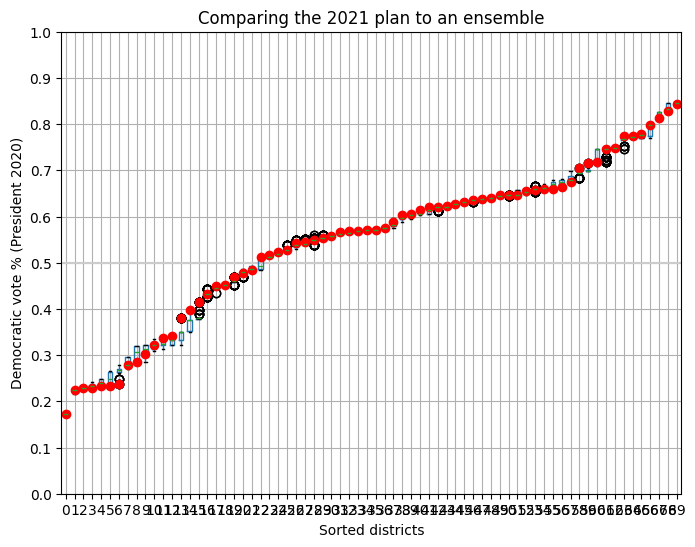

In [77]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data.boxplot(ax=ax, positions=range(len(data.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row, which corresponds to the initial plan)
plt.plot(data.iloc[0], "ro")

# Annotate
ax.set_title("Comparing the 2021 plan to an ensemble")
ax.set_ylabel("Democratic vote % (President 2020)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0.25, 1)
ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.savefig('NMbox_plotPres2020.png')
plt.show()

## Creating output files

Here we'll create some output files for each of our maps. <br>
For each graph, we have one csv with the partisan (election outcome) data, and one csv with the district dual graph data. <br>
We're also outputting the map every 100 steps.

In [78]:
df=gpd.read_file("./NM/NM.shp")

In [97]:
index_output_file = outdir + "index.csv"
print(index_output_file)

./NM_recom/index.csv


In [99]:
with open(index_output_file, mode='w') as index_file:
	index_writer = csv.writer(index_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

	#Run through chain, building 
	for t, part in enumerate(chain):
		if t%save_district_graph_mod==0:
			tmp_str=str(t)
			file_prefix=tmp_str.rjust(8,'0')
	
			#Add file names to index file            
			edges_output_file = outdir + file_prefix + "_edges.csv"
			districts_output_file = outdir + file_prefix + "_districts.csv"
			index_writer.writerow(["./" + file_prefix + "_districts.csv", "./" + file_prefix + "_edges.csv"])
	
	
			#Build the district graph and write edges to file    
			s=set()
			for e in part["cut_edges"]:
				s.add( (part.assignment[e[0]],part.assignment[e[1]] ))
				#s.add( (e[0],e[1]) )
	
			with open(edges_output_file, mode='w') as edges_file:
				edges_writer = csv.writer(edges_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
	
				for e1 in s:
					edges_writer.writerow([e1[0],e1[1]])
	
	
			#Build the district file that contains election results
			D_votes = part["Pres_2020"].votes("Democratic")
			R_votes = part["Pres_2020"].votes("Republican")
	
			with open(districts_output_file, mode='w') as districts_file:
				districts_writer = csv.writer(districts_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
	
				for i in range(len(D_votes)):
					districts_writer.writerow([i+1, int(D_votes[i]),int(R_votes[i]),0])
	
		if t%save_district_plot_mod==0 or t == len(chain):
			df.plot(pd.Series([part.assignment[i] for i in df.index]), cmap="tab20", figsize=(16,8))
			#plt.show()
			plot_output_file = outdir + file_prefix + "_plot.png"
			print(plot_output_file)
			plt.savefig(plot_output_file)
			plt.close()



./NM_recom/00000000_plot.png
./NM_recom/00000010_plot.png
./NM_recom/00000020_plot.png
./NM_recom/00000030_plot.png
./NM_recom/00000040_plot.png
./NM_recom/00000050_plot.png
./NM_recom/00000060_plot.png
./NM_recom/00000070_plot.png
./NM_recom/00000080_plot.png
./NM_recom/00000090_plot.png


And if you want to find the total time:

In [33]:
endrun = datetime.datetime.now()
print ("\nEnd date and time : ", endrun.strftime("%Y-%m-%d %H:%M:%S"))


diff=endrun-beginrun
print("\nTotal time: ", str(diff))


End date and time :  2024-12-16 13:38:31

Total time:  0:01:25.278576
